# Burnout en empleados corporativos
## Análisis de datos - TP 2

Este conjunto de datos fue creado como parte de un estudio de investigación destinado a comprender los factores que contribuyen al agotamiento laboral (*burnout*) de los empleados en entornos corporativos. Los datos fueron recolectados mediante encuestas estructuradas y estudios observacionales realizados en empresas con sede en Bengaluru, India. Se enfoca en una variedad de indicadores relacionados con el bienestar laboral y personal, tales como el equilibrio entre la vida laboral y personal, el apoyo del gerente, los patrones de sueño, la carga de trabajo y el reconocimiento. El conjunto de datos ofrece una visión integral de variables comúnmente asociadas con el estrés y el agotamiento de los empleados, brindando información valiosa para el análisis organizacional y el diseño de estrategias de intervención. *(14-04-2018)*

**Fuente del dataset:**  
Shankar, Kunal, 2018, *"Employee Burnout Analysis"*, Harvard Dataverse, [https://doi.org/10.7910/DVN/VG6KQD](https://doi.org/10.7910/DVN/VG6KQD)  

---
## Carga del dataset y split (train / validation / test)
---

### 1.1. Importación de librerías

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

### 1.2. Cargar datos desde un archivo CSV a un df de Pandas

In [ ]:
# Cargar el dataset original 'enriched_employee_dataset.csv'
df_csv = pd.read_csv("data/enriched_employee_dataset.csv")

In [3]:
# Vista rápida del dataset
df_csv.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Years in Company,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16,16,35,7.5,3,3,1,16,2
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36,16,41,7.1,5,3,3,10,5
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2,NaN,5.8,0.49,16,53,5.7,2,3,5,17,0
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20,16,43,6.7,3,3,1,13,2
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52,16,51,5.2,1,3,4,18,0


### 1.3. Hacer el split del dataset (train / validation / test)

In [4]:
from sklearn.model_selection import train_test_split

# Split inicial: 70% train, 15% validation, 15% test
df_train, df_temp = train_test_split(df_csv, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Confirmar tamaños
print(f"Train: {df_train.shape}, Validation: {df_val.shape}, Test: {df_test.shape}")

Train: (15925, 17), Validation: (3412, 17), Test: (3413, 17)


In [6]:
# Crear tabla resumen
split_summary = pd.DataFrame({
    'Conjunto': ['Train', 'Validation', 'Test'],
    'Cantidad de registros': [len(df_train), len(df_val), len(df_test)]
})

# Calcular el total y el porcentaje
total = len(df_csv)
split_summary['Porcentaje (%)'] = split_summary['Cantidad de registros'] / total * 100

# Mostrar como tabla
split_summary

,Conjunto,Cantidad de registros,Porcentaje (%)
0,Train,15925,70.000000
1,Validation,3412,14.997802
2,Test,3413,15.002198


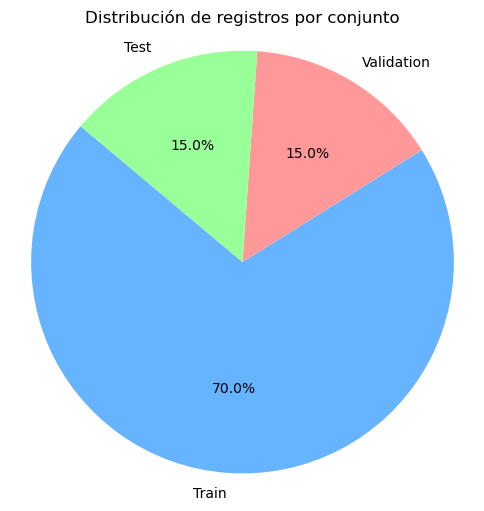

In [8]:
plt.figure(figsize=(6,6))
plt.pie(split_summary['Cantidad de registros'], labels=split_summary['Conjunto'], 
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'], startangle=140)
plt.title('Distribución de registros por conjunto')
plt.axis('equal')
plt.show()

---
## Limpieza de datos
---

### 2.1. Tratamiento de valores nulos en dataset de entrenamiento

In [9]:
#### 2.1 Revisar datos faltantes y duplicados
print(f"Valores faltantes: {df_train.isnull().sum()}")  # Calcular valores faltantes

Valores faltantes: Employee ID                   0
Date of Joining               0
Gender                        0
Company Type                  0
WFH Setup Available           0
Designation                   0
Resource Allocation         943
Mental Fatigue Score       1505
Burn Rate                   773
Years in Company              0
Work Hours per Week           0
Sleep Hours                   0
Work-Life Balance Score       0
Manager Support Score         0
Deadline Pressure Score       0
Team Size                     0
Recognition Frequency         0
dtype: int64


<Axes: >

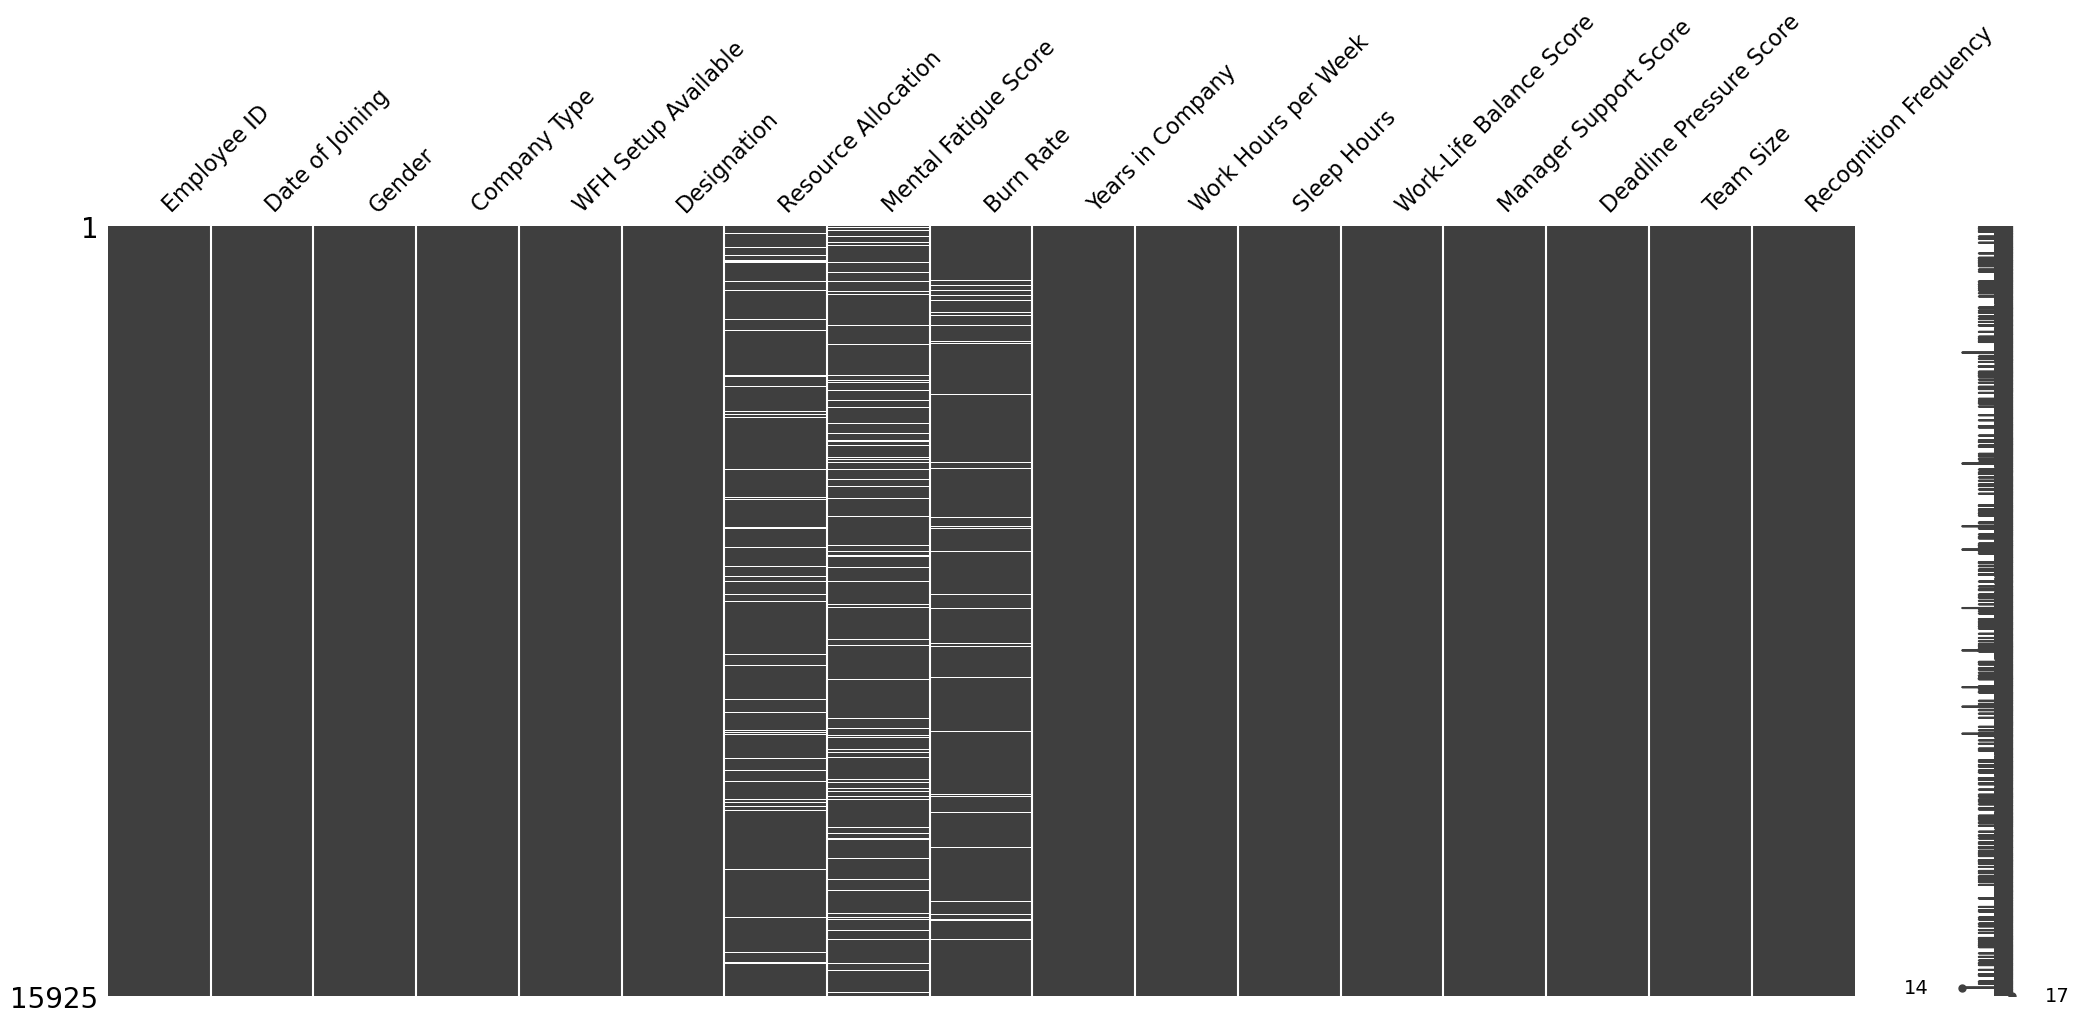

In [15]:
# Visualización de valores faltantes
import missingno as msno
msno.matrix(df_train)

**Más de un nulo:** 

Se eliminan las observaciones que tengan más de un valor nulo, ya que no representan un alto porcentaje del total y podrían ser datos erróneos o haber distintas razones por las que la persona eligió no responder.

In [16]:
# Ver cuántas filas tienen al menos dos nulos
print("Filas con al menos dos nulos:", df_train.isna().sum(axis=1).gt(1).sum())

Filas con al menos dos nulos: 301


In [17]:
# Eliminar filas con dos nulos
df_train_limpio = df_train.dropna(thresh=len(df_train.columns)-1)
print("Filas restantes tras eliminación:", df_train_limpio.shape[0])

Filas restantes tras eliminación: 15624


In [19]:
# Registros restantes en el dataset luego de la limpieza de registros nulos
print("% registros restantes en el dataset:", round((df_train_limpio.shape[0] / df_train.shape[0])*100,2),"%")

% registros restantes en el dataset: 98.11 %


**Burn Rate:** 

Al tratarse de la variable de salida, sería incorrecto imputarle algún valor, ya que esto tendría una gran repercusión en los resultados del modelo y podríamos estar introduciendo ruido. Por esta razón, se eliminan las filas con valores nulos en Burn Rate.

In [20]:
# Eliminar filas con valor nulo en Burn Rate
df_train_limpio = df_train_limpio.dropna(subset=['Burn Rate'])
print("Filas restantes tras eliminación:", df_train_limpio.shape[0])

Filas restantes tras eliminación: 15025


In [21]:
# Comparar antes y después
print("Valores nulos antes de limpieza:\n", df_csv[['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']].isnull().sum())
print("Valores nulos después de limpieza:\n", df_train_limpio[['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']].isnull().sum())

Valores nulos antes de limpieza:
 Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64
Valores nulos después de limpieza:
 Resource Allocation      750
Mental Fatigue Score    1260
Burn Rate                  0
dtype: int64


In [22]:
# Registros restantes en el dataset luego de la limpieza de registros nulos
print("% registros restantes en el dataset:", round((df_train_limpio.shape[0] / df_train.shape[0])*100,2),"%")

% registros restantes en el dataset: 94.35 %


### 2.2. Imputación de 'Mental Fatigue Score' con Regresión Lineal

Se decide imputar los valores faltantes de la variable **'Mental Fatigue Score'** utilizando un modelo de **regresión lineal** basado en las variables con mayor correlación.
Se decide utilizar únicamente las variables con **alta correlación positiva** según lo evaluado en el TP1 para la imputación de valores faltantes.

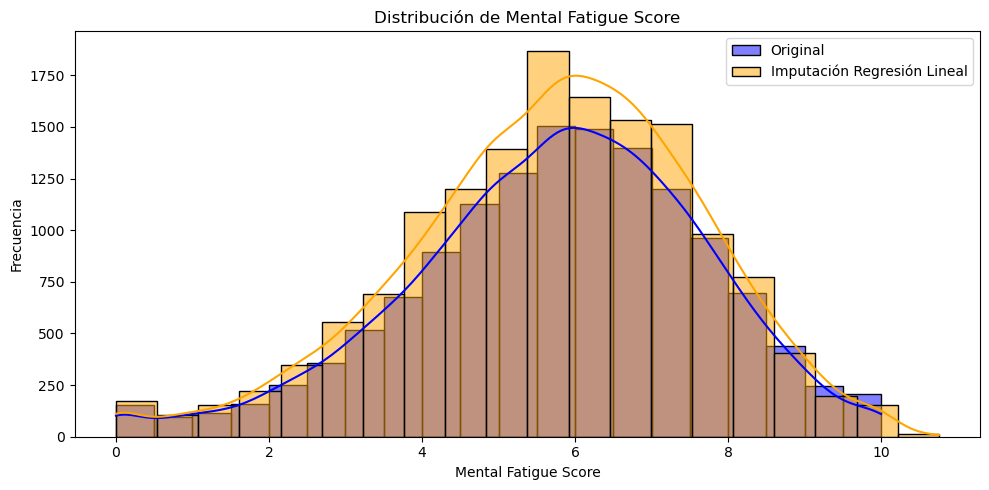

In [27]:
from sklearn.linear_model import LinearRegression

# 1. Preparación del dataset con datos completos para entrenamiento y evaluación para el 'Modelo Simple'

df_mf_train = df_train_limpio[
    df_train_limpio['Mental Fatigue Score'].notnull() &
    df_train_limpio['Designation'].notnull() &
    df_train_limpio['Resource Allocation'].notnull() &
    df_train_limpio['Burn Rate'].notnull() &
    df_train_limpio['Work Hours per Week'].notnull() &
    df_train_limpio['Deadline Pressure Score'].notnull()
]

# Definir variables independientes y dependiente
X_mf = df_mf_train[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]
y_mf = df_mf_train['Mental Fatigue Score']


# 2. Entrenar el modelo y evaluar la capacidad predictiva

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir en train y test para evaluar
X_train, X_test, y_train, y_test = train_test_split(
    X_mf, y_mf, test_size=0.2, random_state=42
)

# Crear y entrenar el modelo
model_mf = LinearRegression()
model_mf.fit(X_train, y_train)

# Predicción en set de test
y_pred = model_mf.predict(X_test)

# 3. Imputación de los valores faltantes de 'Mental Fatigue Score' usando el modelo entrenado ('Modelo simple')

# Filtrar registros con Mental Fatigue Score nulo pero con las otras variables presentes
df_mf_pred = df_train_limpio[
    df_train_limpio['Mental Fatigue Score'].isnull() &
    df_train_limpio['Designation'].notnull() &
    df_train_limpio['Resource Allocation'].notnull() &
    df_train_limpio['Burn Rate'].notnull() &
    df_train_limpio['Work Hours per Week'].notnull() &
    df_train_limpio['Deadline Pressure Score'].notnull()
]

X_mf_pred = df_mf_pred[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]

# Crear una copia del dataframe limpio para guardar los datos imputados
df_train_limpio_MFS_LR = df_train_limpio.copy()

# Aplicar la imputación
df_train_limpio_MFS_LR.loc[df_mf_pred.index, 'Mental Fatigue Score'] = model_mf.predict(X_mf_pred)

# 4. Graficar histograma de 'Mental Fatigue Score' original, con imputación por mediana y con imputación por regresión lineal

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Original
sns.histplot(df_train_limpio['Mental Fatigue Score'], bins=20, kde=True, label='Original', color='blue')

# Con imputación por regresión
sns.histplot(df_train_limpio_MFS_LR['Mental Fatigue Score'], bins=20, kde=True, label='Imputación Regresión Lineal', color='orange')

plt.title('Distribución de Mental Fatigue Score')
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()


### 2.3. Imputación de 'Resource Allocation' con Regresión Lineal

Se decide imputar los valores faltantes de la variable **'Resource Allocation'** utilizando un modelo de **regresión lineal** basado en las variables con mayor correlación.

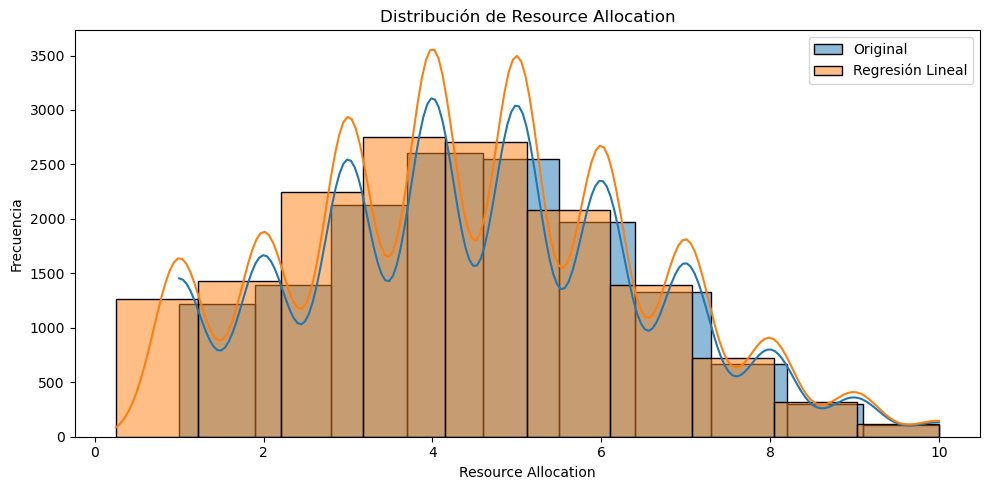

In [28]:
# 1. Preparación del dataset con datos completos para entrenamiento y evaluación para el 'Modelo Simple'
# Dataset para entrenamiento y evaluación (sin nulos en variables predictoras y target)

df_ra_train = df_train_limpio[
    df_train_limpio['Resource Allocation'].notnull() &
    df_train_limpio['Designation'].notnull() &
    df_train_limpio['Burn Rate'].notnull() &
    df_train_limpio['Mental Fatigue Score'].notnull() &
    df_train_limpio['Work Hours per Week'].notnull() &
    df_train_limpio['Deadline Pressure Score'].notnull()
]

# Variables predictoras - Modelo simple
X_ra = df_ra_train[['Designation', 'Burn Rate', 'Mental Fatigue Score',
                     'Work Hours per Week', 'Deadline Pressure Score']]
y_ra = df_ra_train['Resource Allocation']

# 2. Entrenar el modelo y evaluar la capacidad predictiva
# División en train/test
X_train_ra, X_test_ra, y_train_ra, y_test_ra = train_test_split(
    X_ra, y_ra, test_size=0.2, random_state=42
)

# Modelo
model_ra = LinearRegression()
model_ra.fit(X_train_ra, y_train_ra)

# Predicción
y_pred_ra = model_ra.predict(X_test_ra)

# 3. Imputación de los valores faltantes de 'Resource Allocation' usando el modelo entrenado ('Modelo simple')
df_train_limpio=df_train_limpio_MFS_LR.copy()

# Filas completas para entrenamiento
df_ra_train = df_train_limpio[df_train_limpio['Resource Allocation'].notnull() &
                 df_train_limpio['Designation'].notnull() &
                 df_train_limpio['Mental Fatigue Score'].notnull() &
                 df_train_limpio['Burn Rate'].notnull() &
                 df_train_limpio['Work Hours per Week'].notnull()]

X_ra = df_ra_train[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                    'Work Hours per Week']]
y_ra = df_ra_train['Resource Allocation']

model_ra = LinearRegression()
model_ra.fit(X_ra, y_ra)

# Predecir valores nulos
df_ra_pred = df_train_limpio[df_train_limpio['Resource Allocation'].isnull() &
                df_train_limpio['Designation'].notnull() &
                df_train_limpio['Mental Fatigue Score'].notnull() &
                df_train_limpio['Burn Rate'].notnull() &
                df_train_limpio['Work Hours per Week'].notnull()]

X_ra_pred = df_ra_pred[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                        'Work Hours per Week']]

df_train_limpio_RA_LR=df_train_limpio.copy()
df_train_limpio_RA_LR.loc[df_ra_pred.index, 'Resource Allocation'] = model_ra.predict(X_ra_pred)

# 4. Comparar histogramas de 'Resource Allocation' original y con imputación por regresión lineal
plt.figure(figsize=(10, 5))
sns.histplot(df_train_limpio['Resource Allocation'], bins=10, kde=True, label='Original')
sns.histplot(df_train_limpio_RA_LR['Resource Allocation'], bins=10, kde=True, label='Regresión Lineal')
plt.title('Distribución de Resource Allocation')
plt.xlabel('Resource Allocation')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

### 2.4. Verificación de registros restantes en el dataset

In [30]:
df_train_limpio=df_train_limpio_RA_LR.copy()

# Registros restantes en el dataset luego de la limpieza de registros nulos
print("% registros restantes en el dataset:", round((df_train_limpio.shape[0] / df_train.shape[0])*100,2),"%")

% registros restantes en el dataset: 94.35 %


<Axes: >

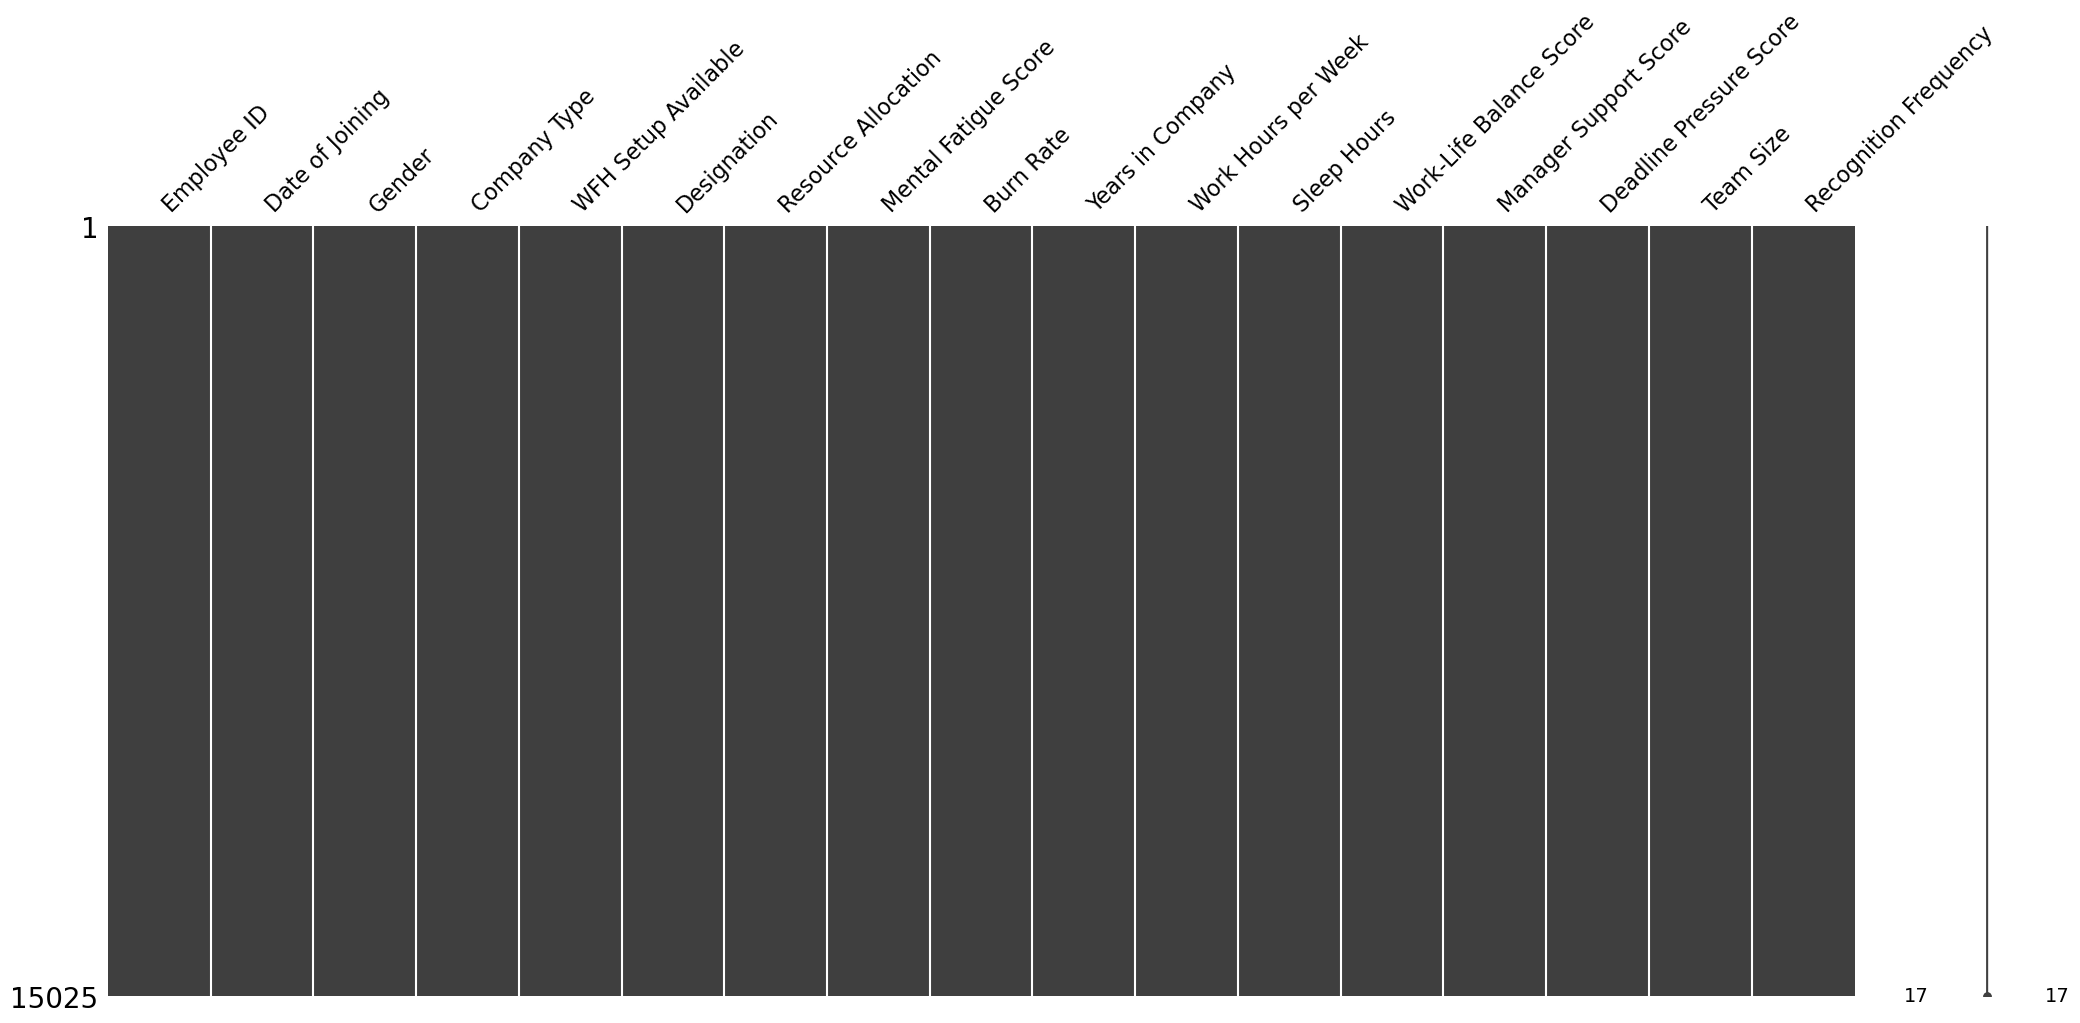

In [31]:
msno.matrix(df_train_limpio)

### 2.5. Tratamiento de valores duplicados

In [32]:
print("Cantidad de datos duplicados:", df_train_limpio.duplicated().sum())

Cantidad de datos duplicados: 0


### 2.6. Ajuste del tipo de datos adecuado para el análisis

In [33]:
print(f"Columnas del dataframe:\n{df_train_limpio.dtypes}\n")

Columnas del dataframe:
Employee ID                 object
Date of Joining             object
Gender                      object
Company Type                object
WFH Setup Available         object
Designation                  int64
Resource Allocation        float64
Mental Fatigue Score       float64
Burn Rate                  float64
Years in Company             int64
Work Hours per Week          int64
Sleep Hours                float64
Work-Life Balance Score      int64
Manager Support Score        int64
Deadline Pressure Score      int64
Team Size                    int64
Recognition Frequency        int64
dtype: object



In [37]:
# Convertir columna de 'Resource Allocation' a tipo integer
df_train_limpio['Resource Allocation'] = df_train_limpio['Resource Allocation'].astype(int)

# Se genera un nuevo dataset sin las columnas Employee ID, Date of Joining, Year
df_train_datatype = df_train_limpio.drop(columns=['Employee ID', 'Date of Joining','Years in Company'])

# Se convierten las columnas categóricas a tipo 'category'
df_train_datatype['Gender']=df_train_datatype['Gender'].astype('category')
df_train_datatype['Company Type']=df_train_datatype['Company Type'].astype('category')
df_train_datatype['WFH Setup Available']=df_train_datatype['WFH Setup Available'].astype('category')
df_train_datatype.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency
6506,Male,Service,No,2,4,5.4,0.31,41,6.7,5,3,2,9,3
12239,Female,Service,Yes,3,4,6.3,0.45,58,5.9,2,3,4,19,0
12441,Male,Service,Yes,2,4,6.1,0.50,52,5.8,2,1,4,15,1
8366,Male,Service,No,2,5,7.6,0.66,52,5.1,2,2,4,19,0
16802,Male,Service,No,3,7,8.8,0.81,53,5.3,2,2,5,7,1


In [38]:
print(f"Columnas del dataframe:\n{df_train_datatype.dtypes}\n")

Columnas del dataframe:
Gender                     category
Company Type               category
WFH Setup Available        category
Designation                   int64
Resource Allocation           int64
Mental Fatigue Score        float64
Burn Rate                   float64
Work Hours per Week           int64
Sleep Hours                 float64
Work-Life Balance Score       int64
Manager Support Score         int64
Deadline Pressure Score       int64
Team Size                     int64
Recognition Frequency         int64
dtype: object

